In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# scikit-learn modules
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.tree import DecisionTreeRegressor # for building the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Initializing the Decision Tree Regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
import pandas as pd


In [40]:
# load data
df = pd.read_csv("MLreadydata.csv")
df = df[df['price'] > 0]
df['price_log'] = df['price'].apply(lambda x: np.log1p(x))

text_cols = ['description']
df['text_all'] = df[text_cols].agg(" ".join, axis=1)


In [25]:
df.columns

Index(['description', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'latitude',
       'longitude',
       ...
       'bathrooms_text_2.5 baths', 'bathrooms_text_3 baths',
       'bathrooms_text_4 baths', 'bathrooms_text_5 baths',
       'bathrooms_text_5.5 baths', 'bathrooms_text_Half-bath',
       'bathrooms_text_Private half-bath', 'bathrooms_text_Shared half-bath',
       'price_log', 'text_all'],
      dtype='object', length=1577)

In [27]:
df.head()

description  \
0  Experience the International Film Festival in Thessaloniki, Greece with a taste of the sea...Want to live in an aquarium? Take the challenge to live in a fully-amenity apartement near famous Chalkidiki beaches and see a lot about sea life as items exposed in the appartement by so close... :)  (The 4th bed is only for baby or young child) (every help or usage of any house amenity is free and not included in the price)   
1                                                                                                                              This is a 3 bedroom apartment in a lovely quite area, full of trees close to:  a) centre of the town - 3 km b) the coastal side of the city which  has recently been granted award for the new design and renovation.  - 150 m away. You will love it. The cost of heating is not included in the price.   
2                                                                                                                                                                            Located on the ground-floor, this studio includes: <br />-free WiFi -a flat-screen TV -a kitchenette with cooking hobs and fridge <br />-a bathroom with shower, hairdryer and free toiletries.Room Size: 20 m²<br />Layout: Private apartment in building   
3                                                                                                                                                                                     Kripis Studio Thessaloniki No4  <br />-Furnished studio with a loft. <br />-On the second floor of the building.<br />-Great view.<br /><br />-The main space has a double bed, kitchen, and spacious bathroom.<br />-The loft has 2 single beds.   
4                                                                                                             My place is close to city center(15 min on foot), restaurant (next corner), supermarket, bakery. You’ll love my place because of the traditional architecture of old city, "village" neighborhood, limited noise and cars and the cozy-sunny internal space. My place is ideal for young couples, and old city explorers.   

   host_response_rate  host_acceptance_rate  host_is_superhost  \
0               100.0                  50.0                0.0   
1                 0.0                 100.0                0.0   
2               100.0                 100.0                1.0   
3               100.0                 100.0                1.0   
4               100.0                 100.0                1.0   

   host_listings_count  host_total_listings_count  host_has_profile_pic  \
0                  2.0                        2.0                   1.0   
1                  1.0                        2.0                   1.0   
2                 11.0                       12.0                   1.0   
3                 11.0                       12.0                   1.0   
4                  1.0                        1.0                   1.0   

   host_identity_verified  latitude  longitude  accommodates  bathrooms  \
0                     0.0  40.57274   22.95667           4.0        1.0   
1                     1.0  40.59683   22.95394           4.0        2.0   
2                     1.0  40.64008   22.95598           2.0        1.0   
3                     1.0  40.64058   22.95678           3.0        1.0   
4                     1.0  40.63780   22.95710           2.0        1.0   

   bedrooms  beds  price  minimum_nights  maximum_nights  \
0       3.0   2.0   56.0             4.0            90.0   
1       3.0   3.0   50.0            28.0          1125.0   
2       0.0   1.0   50.0             7.0          1125.0   
3       1.0   4.0   63.0             7.0          1125.0   
4       0.0   2.0   27.0             3.0            60.0   

   minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  \
0                     4.0                     4.0                    90.0   
1                    28.0          

In [28]:
df.shape

(4047, 1577)

## vorbereiten text und Zielvariable

In [29]:
text_cols = ['description', 'neighborhood_overview', 'host_about']
target_col = 'price'

df = pd.read_csv("listings.csv.gz")
df[text_cols] = df[text_cols].fillna("")
df['price'] = df['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)          
df['text_all'] = df[text_cols].agg(" ".join, axis=1)

# Preis vorbereiten
df = df[df['price'] > 0]
df['price_log'] = df['price'].apply(lambda x: np.log1p(x))

In [41]:
structured_cols = [col for col in df.columns if col not in ['price', 'price_log', 'description', 'text_all']]

# Fehlende Werte in strukturierten Spalten ersetzen
# df[structured_cols] = df[structured_cols].fillna(df[structured_cols].median())

In [42]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [32]:
train_df.shape

(3535, 81)

In [33]:
test_df.shape

(884, 81)

## BERT-Text-Embeddings extrahieren

In [43]:
# BERT vorbereiten
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").to(device)

def get_text_embedding(text, max_len=128):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_len)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = bert(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

def embed_series(series):
    return np.vstack([get_text_embedding(t) for t in tqdm(series)])

# Text Embeddings erzeugen
X_train_text = embed_series(train_df['text_all'])
X_test_text = embed_series(test_df['text_all'])

/Users/philipvonbismarck/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 810/810 [00:57<00:00, 14.07it/s]


In [44]:
X_train_text.shape

(3237, 768)

In [45]:
X_test_text.shape

(810, 768)

In [46]:
X_train_struct = train_df[structured_cols].values
X_test_struct = test_df[structured_cols].values

X_train_full = np.hstack([X_train_struct, X_train_text])
X_test_full = np.hstack([X_test_struct, X_test_text])

y_train = train_df['price_log'].values
y_test = test_df['price_log'].values
y_test_price = np.expm1(y_test)  # Für echte Preise

In [47]:
X_train_full

array([[ 1.00000000e+02,  9.00000000e+01,  0.00000000e+00, ...,
        -3.06009114e-01,  3.68257135e-01,  7.65214786e-02],
       [ 1.00000000e+02,  1.00000000e+02,  0.00000000e+00, ...,
        -5.00395596e-01,  7.56092906e-01,  1.16029330e-01],
       [ 1.00000000e+02,  4.00000000e+01,  0.00000000e+00, ...,
        -3.53313476e-01,  5.19664884e-01,  5.25266603e-02],
       ...,
       [ 1.00000000e+02,  9.20000000e+01,  1.00000000e+00, ...,
        -2.73195598e-02,  2.43190080e-01,  1.79232374e-01],
       [ 9.90000000e+01,  1.00000000e+02,  0.00000000e+00, ...,
        -4.96319562e-01,  2.87963390e-01,  4.27734733e-01],
       [ 1.00000000e+02,  9.60000000e+01,  1.00000000e+00, ...,
        -2.39271760e-01,  4.67718065e-01,  2.70737201e-01]])

In [16]:
train_df[structured_cols].head()

host_response_rate  host_acceptance_rate  host_is_superhost  \
1612               100.0                  90.0                0.0   
3149               100.0                 100.0                0.0   
3480               100.0                  40.0                0.0   
3844               100.0                 100.0                0.0   
3825               100.0                 100.0                0.0   

      host_listings_count  host_total_listings_count  host_has_profile_pic  \
1612                  3.0                        3.0                   1.0   
3149                  1.0                        1.0                   0.0   
3480                  1.0                        2.0                   1.0   
3844                 49.0                       56.0                   0.0   
3825                  1.0                        1.0                   0.0   

      host_identity_verified   latitude  longitude  accommodates  bathrooms  \
1612                     1.0  40.636982  22.950491           4.0        1.5   
3149                     1.0  40.633286  22.946950           4.0        1.0   
3480                     1.0  40.609970  22.959872           4.0        1.0   
3844                     1.0  40.640980  22.937775           4.0        1.0   
3825                     1.0  40.637740  22.937120           2.0        1.0   

      bedrooms  beds  minimum_nights  maximum_nights  minimum_minimum_nights  \
1612       1.0   4.0             2.0           365.0                     2.0   
3149       1.0   1.0             1.0            60.0                     1.0   
3480       1.0   3.0             2.0          1125.0                     2.0   
3844       1.0   2.0             2.0           365.0                     2.0   
3825       0.0   1.0             2.0           365.0                     2.0   

      maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
1612                     2.0                  1125.0                  1125.0   
3149                     1.0                    60.0                    60.0   
3480                     2.0                  1125.0                  1125.0   
3844                     5.0                   365.0                   365.0   
3825                     2.0                   365.0                   365.0   

      minimum_nights_avg_ntm  maximum_nights_avg_ntm  has_availability  \
1612                     2.0                  1125.0               1.0   
3149                     1.0                    60.0               1.0   
3480                     2.0                  1125.0               1.0   
3844                     2.2                   365.0               1.0   
3825                     2.0                   365.0               1.0   

      availability_30  availability_60  availability_90  availability_365  \
1612             30.0             60.0             90.0             365.0   
3149              0.0              0.0              0.0             132.0   
3480              0.0             14.0             44.0             123.0   
3844             14.0             44.0             74.0             165.0   
3825             24.0             54.0             84.0             359.0   

      number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
1612               10.0                    0.0                     0.0   
3149                2.0                    2.0                     0.0   
3480                1.0                    1.0                     0.0   
3844                9.0                    9.0                     4.0   
3825                1.0                    1.0                     0.0   

      availability_eoy  number_of_reviews_ly  estimated_occupancy_l365d  \
1612             289.0                   0.0                        0.0   
3149             132.0                   2.0                       12.0   
3480             123.0                   0.0                        6.0   
3844             165.0          

## Regressionsmodell trainieren

In [49]:

models = {
    "Decision Tree": DecisionTreeRegressor(random_state=0),
    "Random Forest": RandomForestRegressor(random_state=0),
    "XGBoost": XGBRegressor(random_state=0, verbosity=0),
    "Linear Regression": LinearRegression(),
    "MLP": MLPRegressor(hidden_layer_sizes=(256, 128), max_iter=300, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train_full, y_train)
    preds = model.predict(X_test_full)
    
    # Log-RMSE
    rmse_log = mean_squared_error(y_test, preds, squared=False)
    
    # Re-transform predictions to price level
    preds_price = np.expm1(preds)
    
    # Metriken im Preis-Raum
    mse_price = mean_squared_error(y_test_price, preds_price)
    r2_price = r2_score(y_test_price, preds_price)
    mae_price = mean_absolute_error(y_test_price, preds_price)
    medae_price = median_absolute_error(y_test_price, preds_price)
    rmse_price = mean_squared_error(y_test_price, preds_price, squared=False)

    results.append({
        "Modell": name,
        "RMSE (log)": rmse_log,
        "RMSE (Preis €)": rmse_price,
        "MSE (Preis €)": mse_price,
        "R² (Preis €)": r2_price,
        "MAE (Preis €)": mae_price,
        "MedAE (Preis €)": medae_price
    })

# Ergebnisse sortieren nach RMSE im Preis-Raum
results_sorted = sorted(results, key=lambda x: x["RMSE (Preis €)"])
results_df = pd.DataFrame(results_sorted)

# Übersichtliche Ausgabe
print(results_df.to_string(index=False))

/Users/philipvonbismarck/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/philipvonbismarck/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/philipvonbismarck/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/philipvonbismarck/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in versio

           Modell  RMSE (log)  RMSE (Preis €)  MSE (Preis €)  R² (Preis €)  MAE (Preis €)  MedAE (Preis €)
    Random Forest    0.344893       65.654552    4310.520243      0.096844      18.232157         8.890689
              MLP    0.564250       69.346635    4808.955819     -0.007590      32.115905        21.951941
          XGBoost    0.361721      184.207342   33932.344829     -6.109632      23.856563         8.725037
    Decision Tree    0.585324      393.595431  154917.362963    -31.458868      57.493827        12.000000
Linear Regression    0.626350      482.455307  232763.123581    -47.769404      59.737126        14.682840


/Users/philipvonbismarck/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/philipvonbismarck/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## regressionsmodell mit paramtertesting

In [19]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import numpy as np
import pandas as pd

# 🔧 Parameter-Grids für jedes Modell
param_grids = {
    "Linear Regression": [{}],  # bleibt gleich – keine Parameter
    
    "Decision Tree": list(ParameterGrid({
        "max_depth": [5, 10, 20],
        "min_samples_split": [2, 10]
    })),
    
    "Random Forest": list(ParameterGrid({
        "n_estimators": [50, 100],
        "max_depth": [10, 20],
        "min_samples_split": [2, 5]
    })),
    
    "XGBoost": list(ParameterGrid({
        "n_estimators": [50, 100],
        "max_depth": [4, 6],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8],
        "colsample_bytree": [0.8]
    })),
    
    "MLP": list(ParameterGrid({
        "hidden_layer_sizes": [(128,), (256, 128)],
        "activation": ["relu"],
        "solver": ["adam"],
        "alpha": [0.0001, 0.001],
        "max_iter": [300]
    }))
}

# 📦 Alle Ergebnisse hier speichern
results = []

# 🔁 Modelle durchgehen
for model_name, grid in param_grids.items():
    for params in grid:
        if model_name == "Linear Regression":
            model = LinearRegression()
        elif model_name == "Decision Tree":
            model = DecisionTreeRegressor(random_state=42, **params)
        elif model_name == "Random Forest":
            model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
        elif model_name == "XGBoost":
            model = XGBRegressor(random_state=42, n_jobs=-1, verbosity=0, **params)
        elif model_name == "MLP":
            model = MLPRegressor(random_state=42, **params)
        else:
            continue

        model.fit(X_train_full, y_train)
        preds = model.predict(X_test_full)

        # Log-Raum
        rmse_log = mean_squared_error(y_test, preds, squared=False)

        # Preisraum
        preds_price = np.expm1(preds)
        rmse_price = mean_squared_error(y_test_price, preds_price, squared=False)
        mse_price = mean_squared_error(y_test_price, preds_price)
        r2_price = r2_score(y_test_price, preds_price)
        mae_price = mean_absolute_error(y_test_price, preds_price)
        medae_price = median_absolute_error(y_test_price, preds_price)

        results.append({
            "Modell": model_name,
            "Params": params,
            "RMSE (log)": rmse_log,
            "RMSE (Preis €)": rmse_price,
            "MSE (Preis €)": mse_price,
            "R² (Preis €)": r2_price,
            "MAE (Preis €)": mae_price,
            "MedAE (Preis €)": medae_price
        })

# 🧾 Ergebnisse sortieren
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values("RMSE (Preis €)").reset_index(drop=True)

# 🔍 Übersicht
pd.set_option("display.max_colwidth", None)
print(results_df_sorted.to_string(index=False))

/Users/philipvonbismarck/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/philipvonbismarck/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/philipvonbismarck/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/philipvonbismarck/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in versio

           Modell                                                                                                       Params  RMSE (log)  RMSE (Preis €)  MSE (Preis €)  R² (Preis €)  MAE (Preis €)  MedAE (Preis €)
    Random Forest                                               {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}    0.344304    6.560705e+01   4.304285e+03  9.814994e-02   1.827654e+01         9.082116
    Random Forest                                                {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}    0.347048    6.562265e+01   4.306332e+03  9.772112e-02   1.836499e+01         9.251404
    Random Forest                                               {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}    0.344852    6.568448e+01   4.314451e+03  9.602003e-02   1.838032e+01         9.267676
    Random Forest                                                {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}    0.3528

/Users/philipvonbismarck/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/philipvonbismarck/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## plot für besten parameter

/var/folders/88/dgfdtb6n0l3_vyxycsf62vrc0000gn/T/ipykernel_41684/2288094425.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


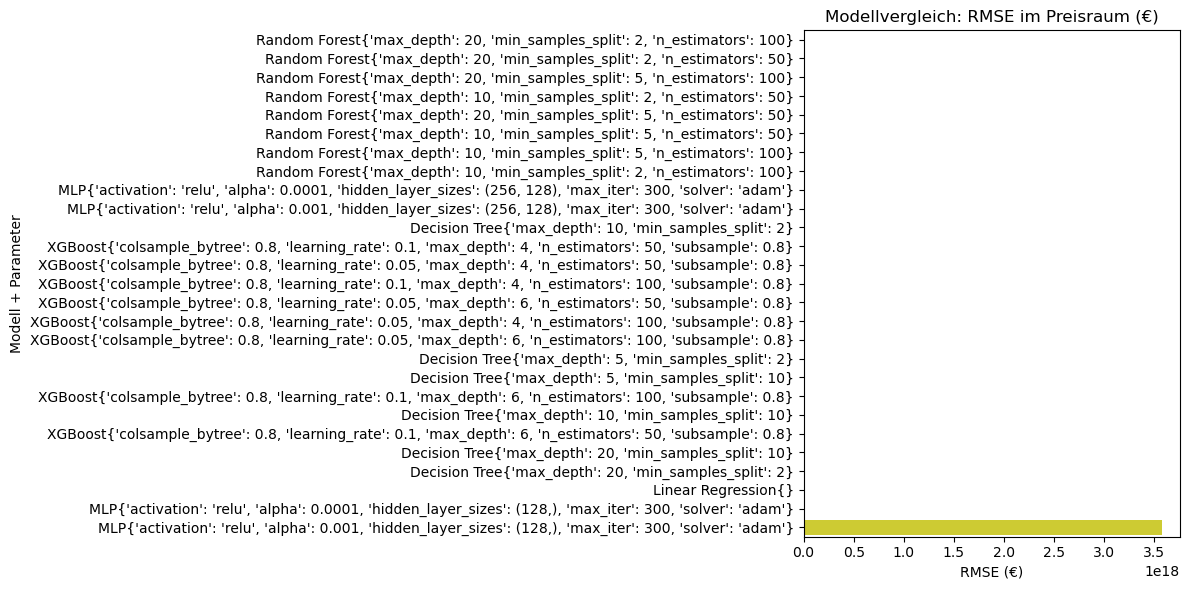

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# 🔁 Ergebnisse sortieren nach RMSE
results_df_sorted = results_df.sort_values("RMSE (Preis €)").reset_index(drop=True)

# 🟢 Plot: RMSE nach Modell + Parameter
plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_df_sorted,
    x="RMSE (Preis €)",
    y=results_df_sorted["Modell"] + results_df_sorted["Params"].astype(str),
    palette="viridis"
)
plt.xlabel("RMSE (€)")
plt.ylabel("Modell + Parameter")
plt.title("Modellvergleich: RMSE im Preisraum (€)")
plt.tight_layout()
plt.show()

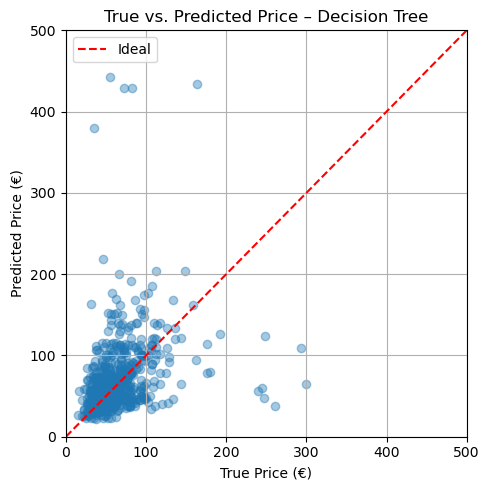

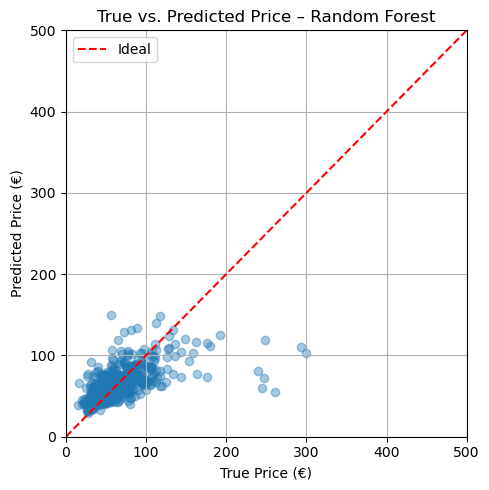

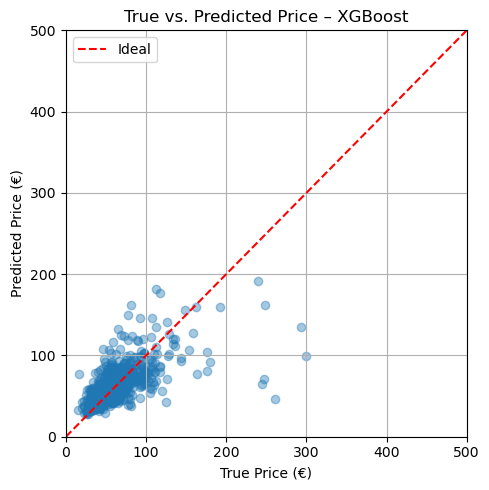

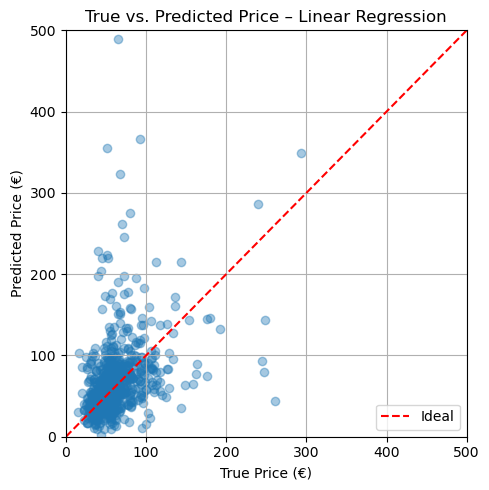

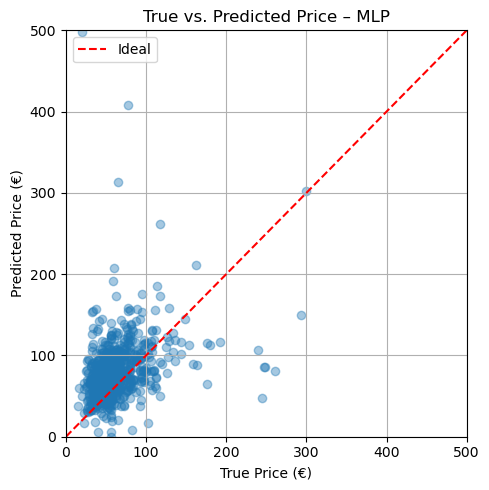

In [50]:
import matplotlib.pyplot as plt

# Für jedes Modell den True-vs-Predicted-Plot anzeigen
for name, model in models.items():
    model.fit(X_train_full, y_train)
    preds = model.predict(X_test_full)
    preds_price = np.expm1(preds)

    plt.figure(figsize=(5, 5))
    plt.scatter(y_test_price, preds_price, alpha=0.4)
    # max_price = max(y_test_price.max(), preds_price.max())
    max_price = 500
    plt.plot([0, max_price], [0, max_price], 'r--', label='Ideal')  # Diagonale
    plt.xlim(0, max_price)
    plt.ylim(0, max_price)
    plt.xlabel("True Price (€)")
    plt.ylabel("Predicted Price (€)")
    plt.title(f"True vs. Predicted Price – {name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Learning Curve für: Linear Regression


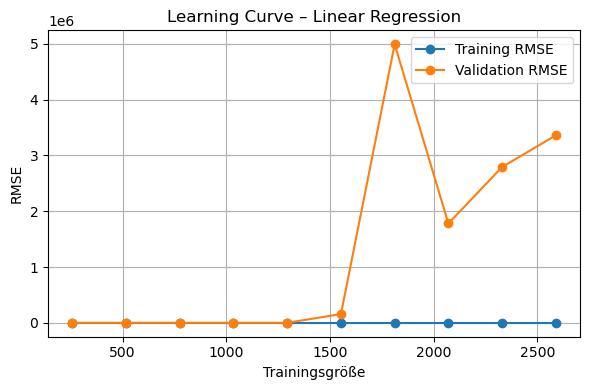

Learning Curve für: Decision Tree


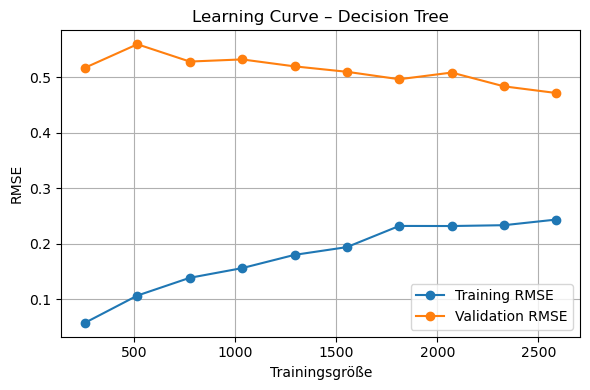

Learning Curve für: Random Forest


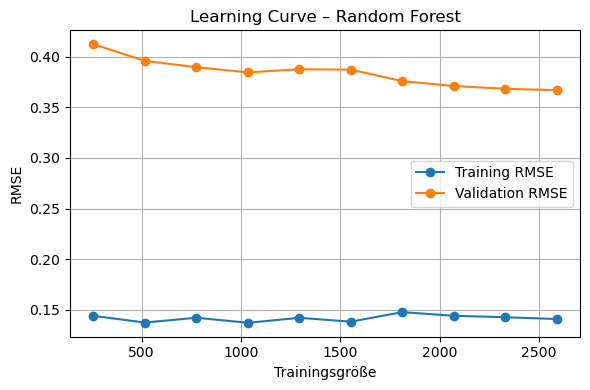

Learning Curve für: XGBoost


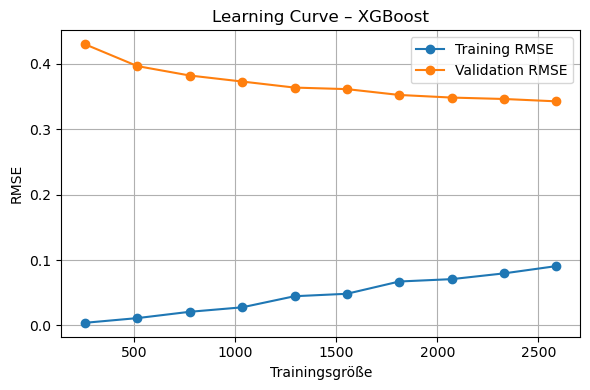

Learning Curve für: MLP


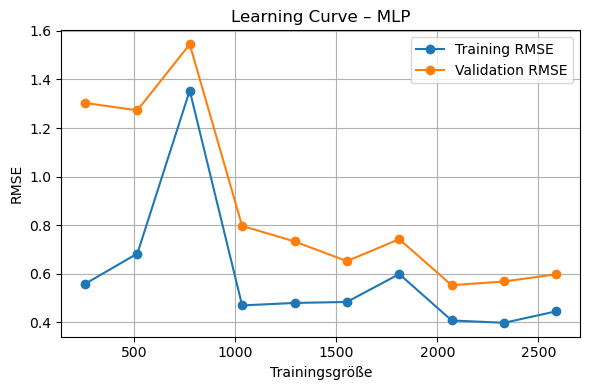

In [22]:
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(model, X, y, title, scoring='neg_mean_squared_error', cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        cv=cv,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1,
        random_state=42
    )

    # Mittelwert und Standardabweichung berechnen
    train_scores_mean = -np.mean(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, np.sqrt(train_scores_mean), 'o-', label="Training RMSE")
    plt.plot(train_sizes, np.sqrt(val_scores_mean), 'o-', label="Validation RMSE")
    plt.xlabel("Trainingsgröße")
    plt.ylabel("RMSE")
    plt.title(f"Learning Curve – {title}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Learning Curves für jedes Modell plotten
for name, model in models.items():
    print(f"Learning Curve für: {name}")
    plot_learning_curve(model, X_train_full, y_train, title=name)

In [20]:
df[['text_all']].head()

,text_all
1,This is a 3 bedroom apartment in a lovely quit...
2,The apartment is located in the heart of the ...
3,The area is really close to the city center o...
4,"Located on the ground-floor, this studio inclu..."
5,"It's impossible to speak about oneself, at l..."
